In [ ]:
!pip install keras_tuner
!pip install bayesian-optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install rdflib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls

confusion_matrix_model1.png  confusion_matrix_model2.png  drive  sample_data


In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sn; sn.set(font_scale=1.4)
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import os
import random
import kerastuner as kt
from keras.layers import Input
from bayes_opt import BayesianOptimization
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping

<ipython-input-5-122b315d6062>:10: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [ ]:
import rdflib
from rdflib import *
from rdflib import URIRef, Graph, Namespace
from rdflib.plugins.parsers.notation3 import N3Parser

In [ ]:
class_names=['buildings', 'forest', 'glacier','mountain','sea','street']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}
nb_classes=len(class_names)
print(class_names_label)
image_size=(150,150)
work_path='/content/drive/Othercomputers/Thinkpad/my folder/Project/imageclassification'

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


In [ ]:
#load dataset
def load_data():
    #directory=os.path.abspath("")
    directory=work_path + '/dataset'
    category=['seg_train','seg_test']
    output=[]
    for eachcategory in category:
        path=os.path.join(directory,eachcategory)
        images=[]
        labels=[]
       
        for folder in os.listdir(path):
            label=class_names_label[folder]
            for file in os.listdir(os.path.join(path, folder)):
                img_path=os.path.join(os.path.join(path,folder),file)
                image=cv2.imread(img_path)
                image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image=cv2.resize(image,image_size)
                
                images.append(image)
                labels.append(label)
        images=np.array(images, dtype='float32')
        labels=np.array(labels, dtype='int32')
        
        output.append((images,labels))
    return output

In [ ]:
(train_images, train_labels), (test_images, test_labels) = load_data()
train_x, val_x, train_y, val_y = train_test_split(train_images, 
                                                  train_labels, 
                                                  stratify=train_labels, 
                                                  random_state=48, 
                                                  test_size=0.05)
(test_x, test_y)=(test_images, test_labels)

In [ ]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)
print(len(train_x))
print(len(val_x))
print(len(test_x))

13281
700
2970


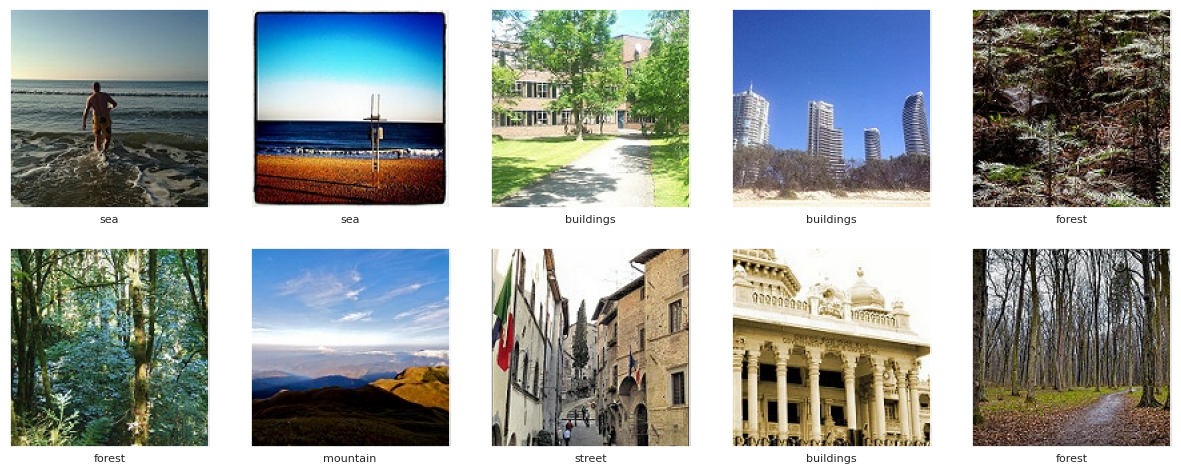

In [ ]:
def display_example(class_name, images, labels):
    figsize=(15,15)
    fig=plt.figure(figsize=figsize)
    #fig.subtitle("Some examples of images from the datset", fontsize=16) - deprecated?
    for i in range(10):
        plt.subplot(5,5, i+1)
        plt.yticks([])
        plt.xticks([])
        plt.grid(False)
        #image=cv2.resize(images[i], figsize)
        #plt.imshow(image.astype(np.uint8))
        plt.imshow(images[i].astype(np.uint8))
        plt.xlabel(class_names[labels[i]],fontsize = 8)
    plt.show()

display_example(class_names,train_images,train_labels)

In [ ]:
train_x = train_x / 255.0
val_x = val_x / 255.0
test_x = test_x / 255.0

train_y = to_categorical(train_y)
val_y = to_categorical(val_y)
test_y = to_categorical(test_y)

In [ ]:
print(train_x.shape)
print(train_y.shape)
print(val_x.shape)
print(val_y.shape)
print(test_x.shape)
print(test_y.shape)

(13281, 150, 150, 3)
(13281, 6)
(700, 150, 150, 3)
(700, 6)
(2970, 150, 150, 3)
(2970, 6)


In [ ]:
# Include Knowledgebase for our project
g=rdflib.Graph()
result=g.parse(file=open(work_path+"/Team3KB.n3", "r"), format="text/n3")

In [ ]:
# at firsy we need check inconsistency
# Include rules
result=g.parse(file=open(work_path+"/Team3Rules.n3", "r"), format="text/n3")
# Let's take a find all class subject and object with owl:oneof properties  
oneofqres=g.query(
    """SELECT DISTINCT ?oneofmembers
        WHERE {
            ind:Settings owl:oneof ?oneofmembers.
        }
    """)
oneofsettingslist=[]
for row in oneofqres:
    oneofind = str(row.asdict()['oneofmembers'].toPython())
    oneofsettingslist.append(oneofind)
print(len(oneofsettingslist))
oneofsettingslist=[w[4:] for w in oneofsettingslist]
print(oneofsettingslist)

8
['inds:layers', 'inds:padding_modes', 'inds:filters_range', 'inds:dropout_range', 'inds:learning_rate', 'inds:optimizer_modes', 'inds:accuracy', 'inds:val_accuracy']


In [ ]:
queryOfSettings = g.query(
        """SELECT DISTINCT ?settings
            WHERE {
            ?settings rdf:type classes:Settings.
            }
        """)
listOfSettings=[]
for row in queryOfSettings:
    settings = str(row.asdict()['settings'].toPython())
    listOfSettings.append(settings)
listOfSettings=[w[4:] for w in listOfSettings]
print(listOfSettings)

['inds:layers', 'inds:padding_modes', 'inds:filters_range', 'inds:dropout_range', 'inds:learning_rate', 'inds:optimizer_modes', 'inds:accuracy', 'inds:val_accuracy']


In [ ]:
print("==== Inconsistency query for owl:oneof ====")

if oneofsettingslist != listOfSettings:
    print("Found inconsistency in:")
    for item in oneofsettingslist:
        print(item)
    for item in listOfSettings:
        print(item)
else:
    print("No inconsistency has been found")

==== Inconsistency query for owl:oneof ====
No inconsistency has been found


In [ ]:
# after check inconsistency in our knowledgebase coressponding our rules 
# let's take parameters for our model of mlalgorithm

In [ ]:
padding_mode_query = g.query(
    """SELECT DISTINCT ?modes
    WHERE {
        ind:padding_modes prop:modes ?modes
    }
    """)
filters_range_query = g.query(
    """SELECT DISTINCT ?filters_range
    WHERE {
        ind:filters_range prop:range ?filters_range
    }
    """)
dropout_range_query = g.query(
    """SELECT DISTINCT ?dropout_range
    WHERE {
        ind:dropout_range prop:range ?dropout_range
    }
    """)
learning_rate_query = g.query(
    """SELECT DISTINCT ?learning_rate
    WHERE {
        ind:learning_rate prop:rate ?learning_rate
    }
    """)
optimizer_modes_query = g.query(
    """SELECT DISTINCT ?modes
    WHERE {
        ind:optimizer_modes prop:modes ?modes
    }
    """)

In [ ]:
len(optimizer_modes_query)

2

In [ ]:
paddings_mode=[]
for row in padding_mode_query:
    paddings_mode.append(str(row.asdict()['modes'].toPython()))
print("Modes of paddings: ", paddings_mode)

filters_range=[]
for row in filters_range_query:
    filters_range.append(int(str(row.asdict()['filters_range'].toPython())))
print("Range for filters: ", filters_range)

dropout_range=[]
for row in dropout_range_query:
    dropout_range.append(float(str(row.asdict()['dropout_range'].toPython())))
print("Range of dropout: ", dropout_range)

learning_rate=[]
for row in learning_rate_query:
    learning_rate.append(float(str(row.asdict()['learning_rate'].toPython())))
print("Rates of learning: ",learning_rate)

optimizer_modes=[]
for row in optimizer_modes_query:
    optimizer_modes.append(str(row.asdict()['modes'].toPython()))
print("Modes of optimizer: ", optimizer_modes)

Modes of paddings:  ['valid', 'same']
Range for filters:  [32, 64]
Range of dropout:  [0.0, 0.1, 0.2]
Rates of learning:  [0.01, 0.001]
Modes of optimizer:  ['Adam', 'SGD']


In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(150, 150, 3)))

    for i in range(hp.Int('num_blocks', 1, 2)):
        hp_padding=hp.Choice('padding_'+ str(i), values=paddings_mode)
        hp_filters=hp.Choice('filters_'+ str(i), values=filters_range)
        model.add(Conv2D(hp_filters, (3, 3), 
                         padding=hp_padding, activation='relu',
                         kernel_initializer='he_uniform',
                         input_shape=(150, 150, 3)))
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(hp.Choice('dropout_'+ str(i), values=dropout_range)))
    model.add(Flatten())

    hp_units = hp.Int('units', min_value=16, max_value=256, step=16)
    model.add(Dense(hp_units, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(6,activation="softmax"))
    hp_learning_rate = hp.Choice('learning_rate', values=learning_rate)
    hp_optimizer=hp.Choice('Optimizer', values=optimizer_modes)

    if hp_optimizer == 'Adam':
        hp_learning_rate = hp.Choice('learning_rate', values=learning_rate)
    elif hp_optimizer == 'SGD':
        hp_learning_rate = hp.Choice('learning_rate', values=learning_rate)
        nesterov=True
        momentum=0.9    
    model.compile(optimizer=hp_optimizer,loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
#This part of code is not needed to run everytime.
#all values of necessary hyperparameters are stored in bestHP variable
#----------------
# tuner_cnn = kt.tuners.BayesianOptimization(
#     build_model,
#     objective='val_loss',
#     max_trials=100,
#     directory='.',
#     project_name='tuning-cnn')

# tuner_cnn.search(train_x, train_y,
#              validation_data= (val_x,val_y), 
#              epochs=30,
#              callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])

# print("________")
# bestHP = tuner_cnn.get_best_hyperparameters(num_trials=1)[0]
# print(bestHP)

In [ ]:
#bestHP.values

In [ ]:
#This values was discovered in previus iteration and using Bayesian optimization
bestHP = {'num_blocks': 2, 'padding_0': 'same', 'filters_0': 32, 'dropout_0': 0.0, 'units': 256, 'learning_rate': 0.001, 'Optimizer': 'Adam', 'padding_1': 'valid', 'filters_1': 32, 'dropout_1': 0.1}

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import h5py

In [ ]:
erl_stop = EarlyStopping(monitor='val_loss', patience = 5, restore_best_weights=True)
mod_chk1 = ModelCheckpoint(filepath='model1.hdf5', monitor='val_loss', save_best_only=True)
mod_chk2 = ModelCheckpoint(filepath='model2.hdf5', monitor='val_loss', save_best_only=True)
mod_chk3 = ModelCheckpoint(filepath='model3.hdf5', monitor='val_loss', save_best_only=True)
lr_rate = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.1)

In [ ]:
model_cnn = Sequential()
model_cnn.add(Input(shape=(150, 150, 3)))
for i in range(bestHP['num_blocks']):
  hp_padding=bestHP['padding_'+ str(i)]
  hp_filters=bestHP['filters_'+ str(i)]
  model_cnn.add(Conv2D(hp_filters, (3, 3), padding=hp_padding, activation='relu',
                       kernel_initializer='he_uniform', input_shape=(150, 150, 3)))
  model_cnn.add(MaxPooling2D((2, 2)))
  model_cnn.add(Dropout(bestHP['dropout_'+ str(i)]))
model_cnn.add(Flatten())
model_cnn.add(Dense(bestHP['units'], activation='relu',
                    kernel_initializer='he_uniform')) 
model_cnn.add(Dense(6,activation="softmax"))
model_cnn.compile(optimizer=bestHP['Optimizer'], 
                                                 loss='categorical_crossentropy', 
                                                 metrics=['accuracy'])
print(model_cnn.summary())

#history_cnn= model_cnn.fit(train_x, train_y, epochs=50, batch_size=32,
#                           validation_data=(val_x, val_y),
#                           callbacks=[erl_stop, mod_chk1, lr_rate])

history_cnn= model_cnn.fit(train_x, train_y, epochs=50, batch_size=32,
                           validation_data=(val_x, val_y))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 75, 75, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 73, 73, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 36, 36, 32)        0

In [ ]:
def plot_accuracy_loss(history):
    fig=plt.figure(figsize=(20,10))
    plt.subplot(221)
    plt.plot(history.history['accuracy'], 'bo--', label='acc')
    plt.plot(history.history['val_accuracy'], 'ro--', label='val_acc')
    plt.title('train_acc VS val_acc')
    plt.ylabel('accuracy')
    plt.xlabel('epochs')
    plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
    plt.rcParams['axes.facecolor'] = 'white'
    plt.legend(fontsize = "large")    
    plt.subplot(222)
    plt.plot(history.history['loss'], 'bo--', label='loss')
    plt.plot(history.history['val_loss'], 'ro--', label='val_loss')
    plt.title('train_loss VS val_loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
    plt.rcParams['axes.facecolor'] = 'white'
    plt.legend()    
    plt.show()

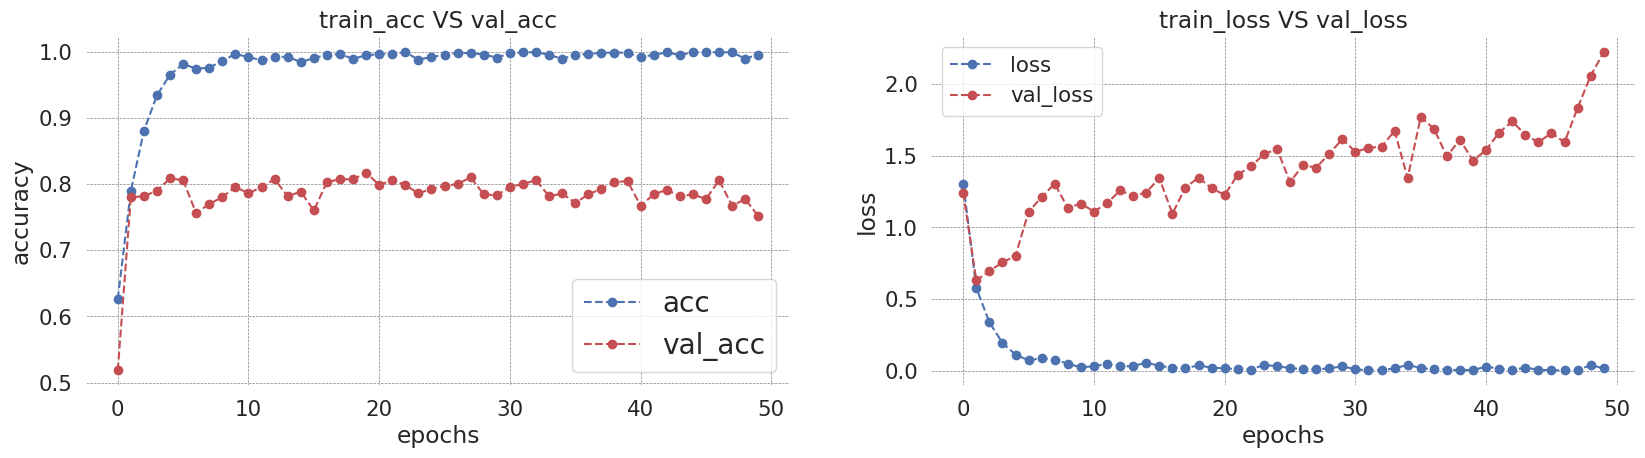

In [ ]:
plot_accuracy_loss(history_cnn)

In [ ]:
model_cnn.save(work_path + '/model1.h5')

In [ ]:
model_cnn_json = model_cnn.to_json()
with open(work_path + '/model1.json','w') as json_file:
  json_file.write(model_cnn_json)

In [ ]:
print("We have " + str(len(train_x)) + " of images in " + str(len(class_names_label)) + " classes")
print("And " + str(len(test_x)) + " test images")

We have 13281 of images in 6 classes
And 2970 test images


In [ ]:
from sklearn.metrics._plot.confusion_matrix import confusion_matrix, ConfusionMatrixDisplay
pred_images = model_cnn.predict(test_images)
pred_labels = np.argmax(pred_images, axis=1)
cm = confusion_matrix(test_labels, pred_labels)
print(cm)
print('\n')
print(classification_report(test_labels, pred_labels))

93/93 [==============================] - 1s 5ms/step
[[285   8  25  18   6  94]
 [ 15 427   7   7   1  15]
 [  4   2 447  69  12   3]
 [ 14   2 130 356  18   5]
 [ 20   2 132  93 240  13]
 [ 68  29   8   6   4 385]]


              precision    recall  f1-score   support

           0       0.70      0.65      0.68       436
           1       0.91      0.90      0.91       472
           2       0.60      0.83      0.70       537
           3       0.65      0.68      0.66       525
           4       0.85      0.48      0.61       500
           5       0.75      0.77      0.76       500

    accuracy                           0.72      2970
   macro avg       0.74      0.72      0.72      2970
weighted avg       0.74      0.72      0.72      2970



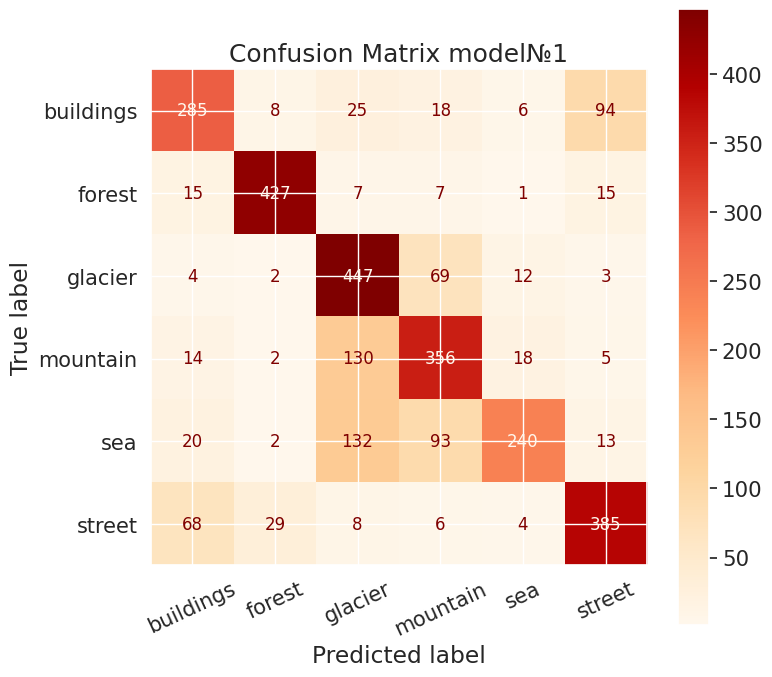

In [ ]:
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['font.size'] = 12
display_c_m = ConfusionMatrixDisplay(cm, display_labels=class_names)
display_c_m.plot(cmap='OrRd', xticks_rotation=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Confusion Matrix model№1', fontsize=18)
plt.savefig(work_path + '/confusion_matrix_model1.png', transparent=True, dpi=300)
plt.show()

In [ ]:
#Precision is the ratio of the correctly +ve labeled by our program to all +ve labeled
#Precision answers the following: How many of those who we labeled as diabetic are actually diabetic
#Recall is the ratio of the correctly +ve labeled by our program to all who are diabetic in reality.
#Recall answers the following question: Of all the people who are diabetic, how many of those we correctly predict?
#F1 Score considers both precision and recall.
#It is the harmonic mean(average) of the precision and recall

/content/drive/Othercomputers/Thinkpad/my folder/Project/imageclassification/testimage1.jpg
1/1 [==============================] - 0s 22ms/step
Results of image classification: [[1. 0. 0. 0. 0. 0.]]
Rounded predict values: [[1. 0. 0. 0. 0. 0.]]
Our image belongs to class: buildings


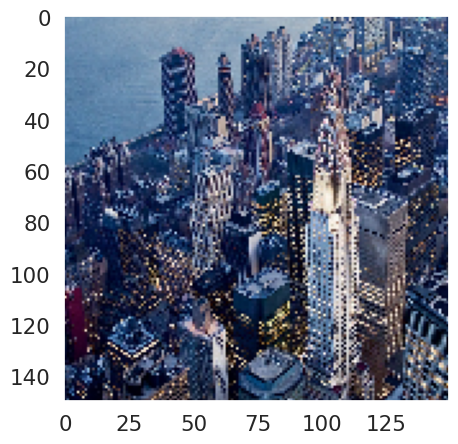

In [ ]:
directory=os.path.abspath("")
test_image_filename= work_path + '/testimage1.jpg'
img_path=os.path.join(directory,test_image_filename)
print(img_path)
image=cv2.imread(img_path)
image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image=cv2.resize(image,image_size)

figsize=(5,5)
fig=plt.figure(figsize=figsize)
plt.imshow(image)
plt.grid(False)
plt.show
image.reshape

y_pred=model_cnn.predict(image.reshape(1, 150,150,3))
pred_label = np.argmax(y_pred, axis=1)
print("Results of image classification:", y_pred)
np.set_printoptions(suppress=True)
print("Rounded predict values:", np.around(y_pred, decimals=2))
print("Our image belongs to class:", class_names[pred_label[0]])


#Now lets do some another model, and after that lets combine them to Ensemble

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D

base_model=VGG16(
    input_shape=(150,150,3),
    weights='imagenet',
    include_top=False
    )

for layer in base_model.layers[:10]:
  layer.trainable=False
    
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(6, activation='softmax')(x)
model2 = Model(inputs=base_model.inputs, outputs=predictions)

In [ ]:
model2.save(work_path + '/model2.h5')

In [ ]:
model2.compile(optimizer=bestHP['Optimizer'],
               loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#history2= model2.fit(train_x, train_y, epochs=50, batch_size=32,
#                      validation_data=(val_x, val_y),
#                      callbacks=[erl_stop, mod_chk2, lr_rate])

history2= model2.fit(train_x, train_y, epochs=50, batch_size=32,
                      validation_data=(val_x, val_y))

Epoch 1/50
416/416 [==============================] - 21s 42ms/step - loss: 0.7779 - accuracy: 0.6900 - val_loss: 0.4493 - val_accuracy: 0.8286
Epoch 2/50
416/416 [==============================] - 16s 38ms/step - loss: 0.4543 - accuracy: 0.8430 - val_loss: 0.4591 - val_accuracy: 0.8543
Epoch 3/50
416/416 [==============================] - 16s 38ms/step - loss: 0.3792 - accuracy: 0.8710 - val_loss: 0.4434 - val_accuracy: 0.8543
Epoch 4/50
416/416 [==============================] - 16s 38ms/step - loss: 0.3477 - accuracy: 0.8783 - val_loss: 0.3212 - val_accuracy: 0.8971
Epoch 5/50
416/416 [==============================] - 16s 38ms/step - loss: 0.3187 - accuracy: 0.8935 - val_loss: 0.3037 - val_accuracy: 0.8900
Epoch 6/50
416/416 [==============================] - 16s 38ms/step - loss: 0.2971 - accuracy: 0.8987 - val_loss: 0.3183 - val_accuracy: 0.8871
Epoch 7/50
416/416 [==============================] - 16s 38ms/step - loss: 0.2768 - accuracy: 0.9034 - val_loss: 0.3327 - val_accuracy:

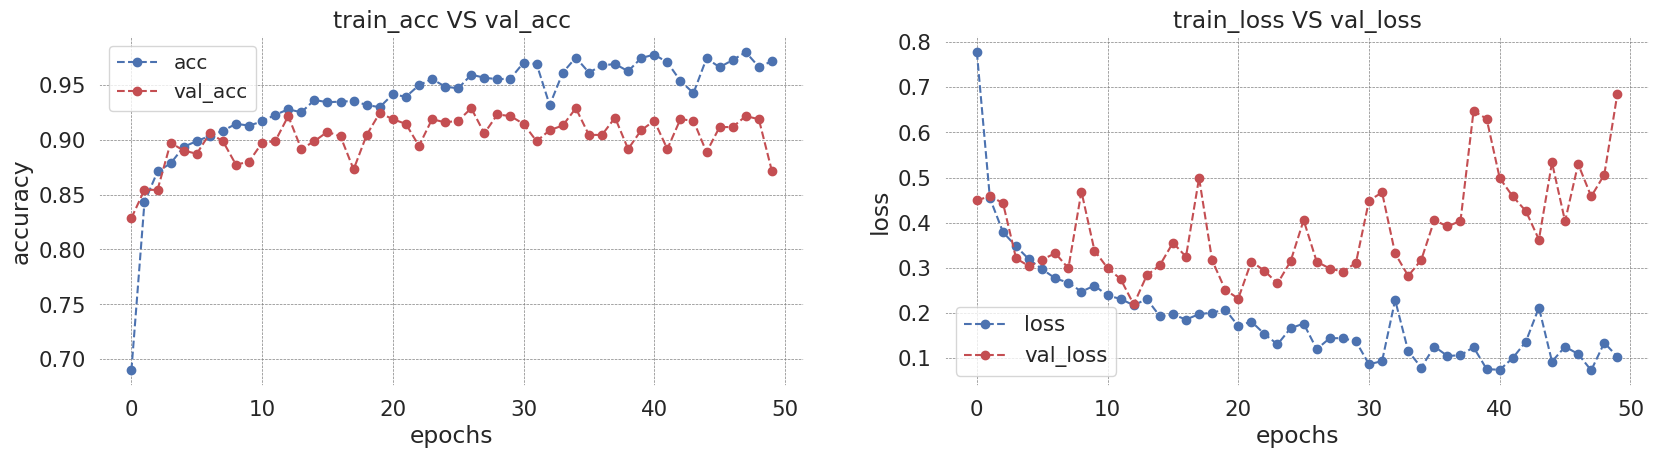

In [ ]:
plot_accuracy_loss(history2)

In [ ]:
model2_json = model2.to_json()
with open(work_path + '/model2.json','w') as json_file:
  json_file.write(model2_json)

In [ ]:
from sklearn.metrics._plot.confusion_matrix import confusion_matrix
pred_images = model2.predict(test_images) #this is vector of probabilities
pred_labels = np.argmax(pred_images, axis=1) #take the highest one prob.
cm2 = confusion_matrix(test_labels, pred_labels)
print(cm2)
print('\n')
print(classification_report(test_labels, pred_labels))

93/93 [==============================] - 2s 22ms/step
[[400   1   0   5   3  27]
 [ 18 360   2  12   2  78]
 [  7   4 279 225  17   5]
 [  9   1  18 477  20   0]
 [ 10   2  11  49 423   5]
 [ 86   0   1   5   3 405]]


              precision    recall  f1-score   support

           0       0.75      0.92      0.83       436
           1       0.98      0.76      0.86       472
           2       0.90      0.52      0.66       537
           3       0.62      0.91      0.73       525
           4       0.90      0.85      0.87       500
           5       0.78      0.81      0.79       500

    accuracy                           0.79      2970
   macro avg       0.82      0.79      0.79      2970
weighted avg       0.82      0.79      0.79      2970



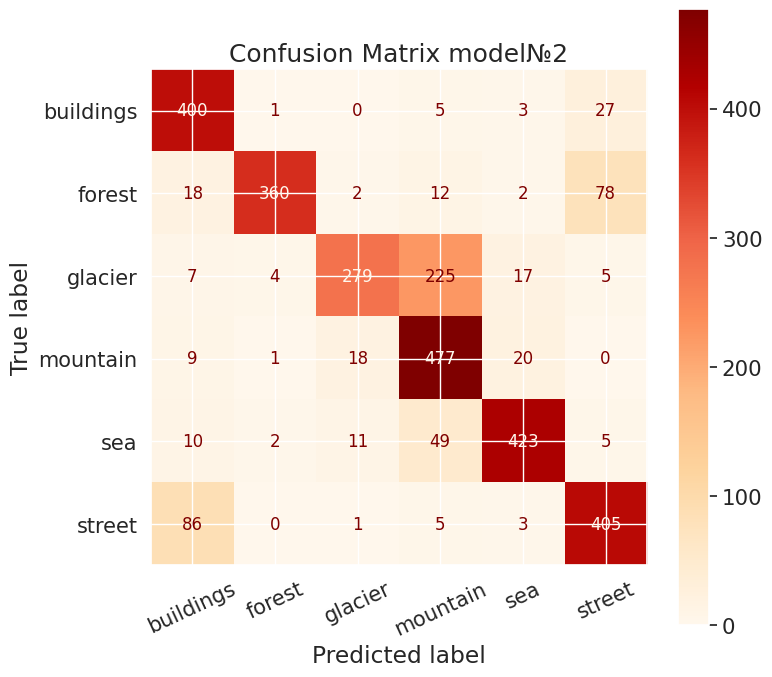

In [ ]:
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['font.size'] = 12
display_c_m = ConfusionMatrixDisplay(cm2, display_labels=class_names)
display_c_m.plot(cmap='OrRd', xticks_rotation=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Confusion Matrix model№2', fontsize=18)
plt.savefig(work_path + '/confusion_matrix_model2.png', transparent=True, dpi=300)
plt.show()

#Now lets compile together two different models (model1 and model2)


In [ ]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Average
#look at the logs correct model names!!!
model_1=load_model(work_path + '/model1.h5')
model_1 = Model(inputs=model_1.inputs,
                outputs=model_1.outputs,
                name='model1')

model_2=load_model(work_path + '/model2.h5')
model_2 = Model(inputs=model_2.inputs,
                outputs=model_2.outputs,
                name='model2')

models = [model_1, model_2]
model_input = Input(shape=(150, 150, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = Average()(model_outputs)
ensemble_model = Model(inputs=model_input, outputs=ensemble_output,
                       name='ensemble')

ensemble_model.compile(optimizer=bestHP['Optimizer'],
                       loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#history=ensemble_model.fit(train_x, train_y, epochs=50, batch_size=256, validation_data=(val_x, val_y), callbacks=[erl_stop, mod_chk3, lr_rate])
history=ensemble_model.fit(train_x, train_y, epochs=50, batch_size=256, validation_data=(val_x, val_y))

In [ ]:
plot_accuracy_loss(history)

In [ ]:
ensemble_model_json = ensemble_model.to_json()
with open(work_path + '/ensemble_model.json','w') as json_file:
  json_file.write(ensemble_model_json)

In [ ]:
from sklearn.metrics._plot.confusion_matrix import confusion_matrix
pred_images = ensemble_model.predict(test_images) #this is vector of probabilities
pred_labels = np.argmax(pred_images, axis=1) #take the highest one prob.
ensemble_cm = confusion_matrix(test_labels, pred_labels)
print(ensemble_cm)
print('\n')
print(classification_report(test_labels, pred_labels))

In [ ]:
ensemble_model.save(work_path + '/model3.h5')

In [ ]:
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['font.size'] = 12
display_c_m = ConfusionMatrixDisplay(ensemble_cm, display_labels=class_names)
display_c_m.plot(cmap='OrRd', xticks_rotation=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Confusion Matrix Ensemble model', fontsize=18)
plt.savefig(work_path + '/confusion_matrix_ensemble_model.png', transparent=True, dpi=300)
plt.show()